In [30]:
import pandas as pd
import os
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, precision_recall_fscore_support
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import time
from pathlib import Path

from extraction import llmAgent
from main import main

In [2]:
recommendation_dict = {
    "continue": [
        "Barretts Esophagus or esophageal cell changes",
        "Chronic Non-Steroidal Anti Inflammatory (NSAID) use or GI prophylaxis NSAID use",
        "Severe esophagitis including bleeding esophagitis or esophageal ulcer",
        "History of gastrointestinal bleeding, gastric ulcer, upper GI bleed, or peptic ulcer hemorrhage",
    ],
    "stop": [
        "Peptic Ulcer Disease or Gastroduodenal ulcer treated for 2 - 12 weeks caused from H Pylori infection or NSAID use without bleeding",
        "Upper GI Symptoms such as reflux, difficulty swallowing, nausea, or vomiting without endoscopy - asymptomatic for 3 consecutive days",
        "ICU Stress Ulcer Prophylaxis",
        "Completed Heliobacter Pylori (H. Pylori) infection treated for 14 days with combination therapy",
    ],
    "deprescribe": [
        "Mild to moderate esophagitis or esophageal inflammation",
        "Treated Gastroesophageal Reflux Disease (GERD) or reflux symptoms such as acid reflux, heartburn, or regurgitation",
    ],
}

In [31]:
def evaluate_multiclass_classification(y_true, y_pred, class_labels):
    """
    Evaluates a multiclass classification model.
    
    y_true: Ground truth labels
    y_pred: Predicted labels from the classifier
    class_labels: List of class names
    
    Returns a dictionary of accuracy, precision, recall, F1, and confusion matrix.
    """
    
    # Accuracy
    accuracy = accuracy_score(y_true, y_pred)
    
    # Precision, Recall, F1-score
    precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='macro')  # macro-averaging
    
    # Classification report (optional detailed breakdown for each class)
    class_report = classification_report(y_true, y_pred, target_names=class_labels)
    
    # Confusion Matrix
    conf_matrix = confusion_matrix(y_true, y_pred)
    
    # Print evaluation metrics
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision (Macro Avg): {precision:.4f}")
    print(f"Recall (Macro Avg): {recall:.4f}")
    print(f"F1 Score (Macro Avg): {f1:.4f}")
    print("\nClassification Report:\n", class_report)
    
    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()
    
    # Return metrics for further analysis if needed
    return {
        "accuracy": accuracy,
        "precision_macro": precision,
        "recall_macro": recall,
        "f1_macro": f1,
        "confusion_matrix": conf_matrix
    }


In [32]:
# path = Path(os.getenv("data_path"))
data_path = Path(r"C:\Users\grays\OneDrive\Documents\GitHub\DataSci210_MedicationDeprescriber\Data")
# groq_key = os.getenv("groqkey")
groq_key = ""

results_path = Path(r"C:\Users\grays\OneDrive\Documents\GitHub\DataSci210_MedicationDeprescriber\Results")

In [33]:
llm_name = "llama-3.1-70b-versatile" # "llama-3.2-90b-vision-preview"

In [34]:
# encounter_key="D6253A5CE371EA"

In [35]:
# recommendation_str, final_reasoning, total_token_count = main(groq_key=groq_key, data_path=data_path, encounter_key=encounter_key)

In [36]:
# recommendation_str, final_reasoning, total_token_count

In [37]:
labeled_data = pd.read_csv(data_path / 'LabeledResponses.csv')
# labeled_data = labeled_data.head(1)
labeled_data

,key,reason,recommendation
0,D6253A5CE371EA,example with gastrointestinal bleed should con...,continue
1,DFAFED1811B871,example with a documented history of a GI blee...,continue
2,D4865B8BBB294E,example with GI bleeding that occurred during ...,continue
3,D00F3A8D5F43B2,example with symptoms of heartburn (upper GI s...,deprescribe
4,D8017C77BA15FA,14d h pylori treatment if pt treated for 2wks ...,stop
5,DA15CCF42ACF8B,"Barrett's esophagus, continue PPI",continue
6,D45728A2EFD315,"example with esophagitis, continue PPI",continue
7,DFB07E6B8F0957,example with chronic NSAID use and pharmacist ...,stop
8,D1BD3665C06499,example where pt should be on due to history o...,continue
9,D068E26FFF9F43,example where pt came in on and no clear reaso...,stop


In [38]:
results_df = pd.DataFrame(columns=['key', 'rec', 'response'])

for key in labeled_data['key']:
    start = time.time()
    print(f"Encounter key: {key}.")
    try:
        recommendation_str, final_reasoning, total_token_count = main(groq_key=groq_key, data_path=data_path, encounter_key=key)
    except:
        print(f"Error with key: {key}")
        recommendation_str, final_reasoning, total_token_count = None, None, None
    
    new_row = pd.DataFrame([{'key': key, 'rec': recommendation_str, 'response': final_reasoning, 'token_count': total_token_count}])
    results_df = pd.concat([results_df, new_row], ignore_index=True)
    print(f"{key} took {time.time() - start} seconds to process.")

results_df.to_csv(results_path / f'model_results_{llm_name}.csv', index=False)

Encounter key: D6253A5CE371EA.
D6253A5CE371EA took 22.917264461517334 seconds to process.
Encounter key: DFAFED1811B871.
DFAFED1811B871 took 44.38870096206665 seconds to process.
Encounter key: D4865B8BBB294E.
D4865B8BBB294E took 51.763906955718994 seconds to process.
Encounter key: D00F3A8D5F43B2.
Error with key: D00F3A8D5F43B2
D00F3A8D5F43B2 took 93.4570984840393 seconds to process.
Encounter key: D8017C77BA15FA.


C:\Users\grays\AppData\Local\Temp\ipykernel_28872\77463525.py:13: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, new_row], ignore_index=True)


D8017C77BA15FA took 306.56620740890503 seconds to process.
Encounter key: DA15CCF42ACF8B.
DA15CCF42ACF8B took 39.048301696777344 seconds to process.
Encounter key: D45728A2EFD315.
D45728A2EFD315 took 102.70751118659973 seconds to process.
Encounter key: DFB07E6B8F0957.
DFB07E6B8F0957 took 33.6825225353241 seconds to process.
Encounter key: D1BD3665C06499.
D1BD3665C06499 took 50.615124464035034 seconds to process.
Encounter key: D068E26FFF9F43.
D068E26FFF9F43 took 35.55176663398743 seconds to process.
Encounter key: D0E44FD0BBD96F.
Error with key: D0E44FD0BBD96F
D0E44FD0BBD96F took 93.44688582420349 seconds to process.
Encounter key: D17AFAD1D7BB68.


C:\Users\grays\AppData\Local\Temp\ipykernel_28872\77463525.py:13: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  results_df = pd.concat([results_df, new_row], ignore_index=True)


D17AFAD1D7BB68 took 34.49645495414734 seconds to process.
Encounter key: DAA6DE9D2EC973.
DAA6DE9D2EC973 took 51.984211683273315 seconds to process.
Encounter key: D5A7045ED60A2E.
D5A7045ED60A2E took 38.53019595146179 seconds to process.
Encounter key: D4BAEF91CA7588.
D4BAEF91CA7588 took 190.3470458984375 seconds to process.
Encounter key: DACBDED2F35C67.
DACBDED2F35C67 took 52.255104064941406 seconds to process.
Encounter key: DA44DBBF3CCE49.
DA44DBBF3CCE49 took 56.869630336761475 seconds to process.
Encounter key: DAABF28BCE02C7.
DAABF28BCE02C7 took 47.49634552001953 seconds to process.


In [39]:
results_df

,key,rec,response,token_count
0,D6253A5CE371EA,continue,The patient has experienced bleeding in the ga...,6102.0
1,DFAFED1811B871,continue,The reasoning provided in the three JSON files...,7458.0
2,D4865B8BBB294E,continue,The patient's gastrointestinal health status i...,4576.0
3,D00F3A8D5F43B2,None,None,NaN
4,D8017C77BA15FA,continue,The 'Reasoning' key provides explanations for ...,6571.0
5,DA15CCF42ACF8B,continue,The provided JSON information does not contain...,6224.0
6,D45728A2EFD315,deprescribe,The 'Reasoning' key provides explanations for ...,5907.0
7,DFB07E6B8F0957,continue,The provided information does not contain suff...,6231.0
8,D1BD3665C06499,continue,The provided information does not contain suff...,5924.0
9,D068E26FFF9F43,continue,The 'Reasoning' key in each JSON file provides...,4182.0


In [40]:
# remove rows with None (failed keys)
failed_keys = ["D00F3A8D5F43B2", "D0E44FD0BBD96F"]
results_df_temp = results_df[~results_df['key'].isin(failed_keys)]
results_df_temp

,key,rec,response,token_count
0,D6253A5CE371EA,continue,The patient has experienced bleeding in the ga...,6102.0
1,DFAFED1811B871,continue,The reasoning provided in the three JSON files...,7458.0
2,D4865B8BBB294E,continue,The patient's gastrointestinal health status i...,4576.0
4,D8017C77BA15FA,continue,The 'Reasoning' key provides explanations for ...,6571.0
5,DA15CCF42ACF8B,continue,The provided JSON information does not contain...,6224.0
6,D45728A2EFD315,deprescribe,The 'Reasoning' key provides explanations for ...,5907.0
7,DFB07E6B8F0957,continue,The provided information does not contain suff...,6231.0
8,D1BD3665C06499,continue,The provided information does not contain suff...,5924.0
9,D068E26FFF9F43,continue,The 'Reasoning' key in each JSON file provides...,4182.0
11,D17AFAD1D7BB68,deprescribe,The 'Reasoning' key explanations can be summar...,6340.0


In [41]:
labeled_data_temp = labeled_data[~labeled_data['key'].isin(failed_keys)]
labeled_data_temp

,key,reason,recommendation
0,D6253A5CE371EA,example with gastrointestinal bleed should con...,continue
1,DFAFED1811B871,example with a documented history of a GI blee...,continue
2,D4865B8BBB294E,example with GI bleeding that occurred during ...,continue
4,D8017C77BA15FA,14d h pylori treatment if pt treated for 2wks ...,stop
5,DA15CCF42ACF8B,"Barrett's esophagus, continue PPI",continue
6,D45728A2EFD315,"example with esophagitis, continue PPI",continue
7,DFB07E6B8F0957,example with chronic NSAID use and pharmacist ...,stop
8,D1BD3665C06499,example where pt should be on due to history o...,continue
9,D068E26FFF9F43,example where pt came in on and no clear reaso...,stop
11,D17AFAD1D7BB68,should stop PPI based on Fundoplication being ...,stop


In [42]:
y_true = labeled_data_temp['recommendation']
y_pred = results_df_temp['rec']
class_labels = ['continue', 'deprescribe', 'stop']

Accuracy: 0.3750
Precision (Macro Avg): 0.1818
Recall (Macro Avg): 0.2857
F1 Score (Macro Avg): 0.2222

Classification Report:
               precision    recall  f1-score   support

    continue       0.55      0.86      0.67         7
 deprescribe       0.00      0.00      0.00         0
        stop       0.00      0.00      0.00         9

    accuracy                           0.38        16
   macro avg       0.18      0.29      0.22        16
weighted avg       0.24      0.38      0.29        16



c:\Users\grays\anaconda3\envs\capstone\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\grays\anaconda3\envs\capstone\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\grays\anaconda3\envs\capstone\Lib\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Use

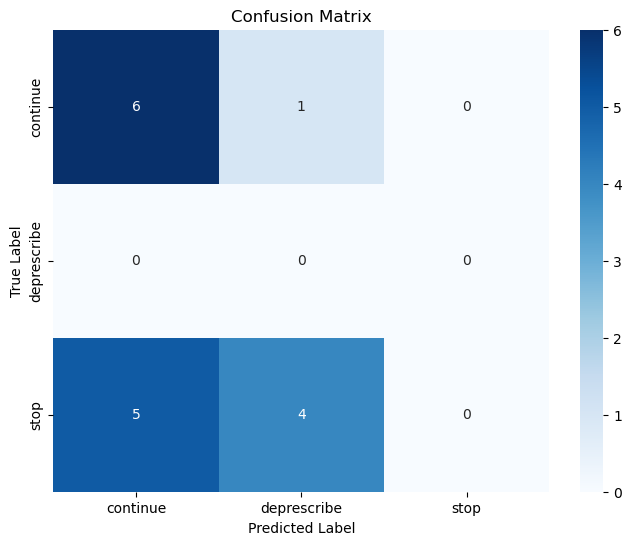

In [43]:
# Evaluate the model
metrics = evaluate_multiclass_classification(y_true, y_pred, class_labels)

In [3]:
load_dotenv()

groq = os.getenv("groqkey")

evaluator_llm = LangchainLLMWrapper(ChatGroq(temperature=0, model="llama-3.1-70b-versatile", api_key=groq))
evaluator_embeddings = LangchainEmbeddingsWrapper(HuggingFaceEmbeddings(model_name="NeuML/pubmedbert-base-embeddings"))

def calculate_RAGAS_answer(generated_answer, gold_answer, question, context):
  data = {'question': [question],
          'contexts': [context],
          'answer': [generated_answer],
          'ground_truth': [gold_answer]}
  dataset = Dataset.from_dict(data)
  score = evaluate(dataset, llm=evaluator_llm, embeddings=evaluator_embeddings, metrics = [faithfulness, answer_relevancy, context_precision, context_recall]).to_pandas()
  faithfulness_score = score['faithfulness'].iloc[0]
  answer_relevancy_score = score['answer_relevancy'].iloc[0]
  context_precision_score = score['context_precision'].iloc[0]
  context_recall_score = score['context_recall'].iloc[0]
  return faithfulness_score, answer_relevancy_score, context_precision_score, context_recall_score

C:\Users\krisr\AppData\Local\Temp\ipykernel_30464\3110027476.py:6: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  evaluator_embeddings = LangchainEmbeddingsWrapper(HuggingFaceEmbeddings(model_name="NeuML/pubmedbert-base-embeddings"))


In [6]:
import pandas as pd
from fastapi import FastAPI
from fastapi.responses import HTMLResponse
import uvicorn
from IPython.display import Markdown, display
from extraction import llmAgent
from ppi_deprescribe import merge_results, ppi_deprescribe
import os 
from pathlib import Path
from dotenv import load_dotenv

load_dotenv()

# path = Path(os.getenv("data_path"))
data_path = Path(r"C:\Users\grays\OneDrive\Documents\GitHub\DataSci210_MedicationDeprescriber\Data")
# groq_key = os.getenv("groqkey")
groq_key = "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"

def deprescribe(encounter_key):
    # extract information
    llm_agent = llmAgent(groq_key=groq_key, data_path=data_path)

    diagnosis_json, diagnosis_token_count = llm_agent.extract_diagnosis(
        encounter_key=encounter_key
    )
    encounter_json, encounter_token_count = llm_agent.extract_encounter_info(
        encounter_key=encounter_key
    )
    # NOTE notes_context is a list of Document objects for RAGAs metrics
    notes_json, notes_token_count, notes_context = llm_agent.extract_notes(
        encounter_key=encounter_key
    )

    results_dict = {
        "diagnosis_dict": diagnosis_json,
        "encounter_dict": encounter_json,
        "notes_dict": notes_json,
    }

    # # #   master formatter step   # # #
    # merge the diagnosis booleans (just use OR logic for now)
    # make a final "reasoning" behind the recommendation
    final_dict = merge_results(results_dict=results_dict)

    # feed the three reasonings to LLM to get a single summary
    final_reasoning, reasoning_summary_token_count = llm_agent.summarize_reasonings(
        results_dict=results_dict
    )

    # count tokens used by LLM queries
    total_token_count = (
        diagnosis_token_count
        + encounter_token_count
        + notes_token_count
        + reasoning_summary_token_count
    )

    # # #   get recommendation from PPI algorithm   # # #
    recommendation_str = ppi_deprescribe(patient_diagnosis=final_dict)
    
    return recommendation_str, final_reasoning, total_token_count
    #print("Recommendation: ")
    #print(recommendation_str)
    #print("\nReasoning: ")
    #print(final_reasoning)

In [ ]:
load_dotenv()

data = pd.read_csv(path / 'LabeledResponses.csv')

results_df = pd.DataFrame(columns=['key', 'rec', 'response'])

for key in data['key']:
    start = time.time()
    print(f"Starting key: {key}.")
    response = deprescribe(key)
    new_row = pd.DataFrame([{'key': key, 'rec': response[0], 'response': response[1]}])
    results_df = pd.concat([results_df, new_row], ignore_index=True)
    print(f"{key} took {time.time() - start} seconds to process.")

results_df.to_csv(path / 'model_results.csv', index=False)

In [ ]:
# load data
data = pd.read_csv(path / 'LabeledResponses_ReturnedResponse.csv')

y_true = data['recommendation']
y_pred = data['Rec_Returned']
class_labels = ['continue', 'deprescribe', 'stop']

# Evaluate the model
metrics = evaluate_multiclass_classification(y_true, y_pred, class_labels)

In [ ]:
from extraction import llmAgent
from ppi_deprescribe import merge_results

llm_agent = llmAgent(groq_key=groq, data_path=path)

data = pd.read_csv(path / 'LabeledResponses_ReturnedResponse.csv')

ragas_results_df = pd.DataFrame(columns=['key', 'ragas_score'])

for key in data['key']:
    print(f"Starting key {key}")
    start = time.time()

    temp = data[data['key'] == key]
    temp = temp.reset_index()

    results_dict = {
        "diagnosis_dict": llm_agent.extract_diagnosis(encounter_key=key),
        "encounter_dict": llm_agent.extract_encounter_info(encounter_key=key),
        "notes_dict": llm_agent.extract_notes(encounter_key=key),
    }
    final_dict = merge_results(results_dict=results_dict)

    final_reasoning = llm_agent.summarize_reasonings(results_dict=results_dict)

    generated_answer = temp['Reasoning'][0]
    gold_answer = temp['GS_response'][0]
    question = "You are a knowledgeable medical provider who specializes in medication management. Given a list of diagnosis and some snippets from patients notes, answer if the patient notes contain any of the diagnosis. Based on the information from the note context, does the patient have any of the following: 1. Mild to moderate esophagitis 2. GERD 3. Peptic Ulcer Disease 4. Upper GI symptoms 5. ICU Stress Ulcer Prophylaxis 6. Barretts Esophagus 7. Chronic NSAID use with bleeding risk 8. Severe esophagitis 9. Documented history of bleeding GI ulcer 10. H pylori infection 11. Explain the reasoning for your answer. Return the answer for each of these as a formatted JSON object with the key being the condition and the value being a boolean value for the first 10.  For the final question, return a string with the reasoning for your answer. Summarize the reasonings from the three sources. You are a knowledgeable medical provider who specializes in medication management. Based on the following json files, please provide a single explanation of the reasoning given by the 'Reasoning' key. Summarize given equal weight to each. Do not add any additional information, only summarize what is given." 
    context = [final_reasoning]

    ragas_score = calculate_RAGAS_answer(generated_answer, gold_answer, question, context)

    print(ragas_score)
    print(f"{key} took {time.time() - start} seconds to process.")

    new_row = pd.DataFrame([{'key': key, 'ragas_score': ragas_score}])
    ragas_results_df = pd.concat([ragas_results_df, new_row], ignore_index=True)

ragas_results_df.to_csv(path / 'model_results.csv', index=False)
